In [1]:
import pandas as pd
import numpy as np

# Load segment-level CLV dynamics from Phase 1
segment_ts = pd.read_csv("../../core/data/processed/segment_clv_dynamics.csv")

segment_ts["order_month"] = pd.to_datetime(segment_ts["order_month"])

segment_ts.head()

,segment,order_month,segment_value,active_customers,avg_value_per_customer
0,0.0,2022-01-01,432.970,222,1.950315
1,0.0,2022-02-01,356.090,192,1.854635
2,0.0,2022-03-01,360.050,199,1.809296
3,0.0,2022-04-01,299.700,163,1.838650
4,0.0,2022-05-01,266.565,155,1.719774


In [2]:
segment_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   segment                 96 non-null     float64       
 1   order_month             96 non-null     datetime64[ns]
 2   segment_value           96 non-null     float64       
 3   active_customers        96 non-null     int64         
 4   avg_value_per_customer  96 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 3.9 KB


In [3]:
segment_ts.isnull().sum()

segment                   0
order_month               0
segment_value             0
active_customers          0
avg_value_per_customer    0
dtype: int64

In [4]:
segment_ts.groupby("segment")["order_month"].nunique()

segment
0.0    24
1.0    24
2.0    24
3.0    24
Name: order_month, dtype: int64

In [5]:
segment_ts = segment_ts.sort_values(
    ["segment", "order_month"]
).reset_index(drop=True)

segment_ts.head()

,segment,order_month,segment_value,active_customers,avg_value_per_customer
0,0.0,2022-01-01,432.970,222,1.950315
1,0.0,2022-02-01,356.090,192,1.854635
2,0.0,2022-03-01,360.050,199,1.809296
3,0.0,2022-04-01,299.700,163,1.838650
4,0.0,2022-05-01,266.565,155,1.719774


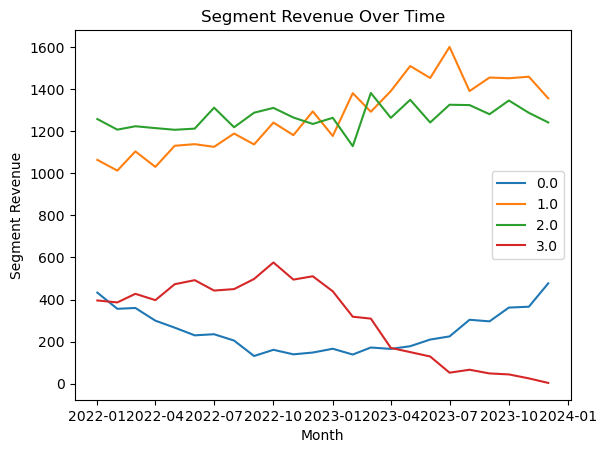

In [6]:
import matplotlib.pyplot as plt

for seg in segment_ts["segment"].unique():
    subset = segment_ts[segment_ts["segment"] == seg]
    plt.plot(subset["order_month"], subset["segment_value"], label=seg)

plt.title("Segment Revenue Over Time")
plt.xlabel("Month")
plt.ylabel("Segment Revenue")
plt.legend()
plt.show()

In [7]:
# Split point (last 3 months for testing)
split_date = segment_ts["order_month"].max() - pd.DateOffset(months=3)

train_data = segment_ts[segment_ts["order_month"] <= split_date]
test_data  = segment_ts[segment_ts["order_month"] > split_date]

train_data.tail(), test_data.head()

(    segment order_month  segment_value  active_customers  \
 88      3.0  2023-05-01         150.48                76   
 89      3.0  2023-06-01         129.56                68   
 90      3.0  2023-07-01          52.72                33   
 91      3.0  2023-08-01          66.65                37   
 92      3.0  2023-09-01          49.10                26   
 
     avg_value_per_customer  
 88                1.980000  
 89                1.905294  
 90                1.597576  
 91                1.801351  
 92                1.888462  ,
     segment order_month  segment_value  active_customers  \
 21      0.0  2023-10-01     361.960000               192   
 22      0.0  2023-11-01     366.005000               195   
 23      0.0  2023-12-01     476.915000               246   
 45      1.0  2023-10-01    1451.201667               742   
 46      1.0  2023-11-01    1458.341667               739   
 
     avg_value_per_customer  
 21                1.885208  
 22                1.87

In [8]:
naive_forecasts = []

for seg in train_data["segment"].unique():
    last_value = train_data[train_data["segment"] == seg]["segment_value"].iloc[-1]
    
    future_months = test_data[test_data["segment"] == seg]["order_month"]
    
    for m in future_months:
        naive_forecasts.append({
            "segment": seg,
            "order_month": m,
            "forecast": last_value
        })

naive_forecast_df = pd.DataFrame(naive_forecasts)
naive_forecast_df.head()

,segment,order_month,forecast
0,0.0,2023-10-01,296.470000
1,0.0,2023-11-01,296.470000
2,0.0,2023-12-01,296.470000
3,1.0,2023-10-01,1454.501667
4,1.0,2023-11-01,1454.501667


In [9]:
from sklearn.metrics import mean_absolute_error

evaluation = test_data.merge(
    naive_forecast_df,
    on=["segment", "order_month"]
)

mae_naive = mean_absolute_error(
    evaluation["segment_value"],
    evaluation["forecast"]
)

mae_naive

50.425972222222185

In [11]:
import numpy as np

window = 3
ma_forecasts = []

for seg in train_data["segment"].unique():
    seg_train = (
        train_data[train_data["segment"] == seg]
        .sort_values("order_month")
    )
    
    seg_test = (
        test_data[test_data["segment"] == seg]
        .sort_values("order_month")
    )

    last_values = seg_train["segment_value"].tail(window).tolist()

    for m in seg_test["order_month"]:
        forecast_value = np.mean(last_values)

        ma_forecasts.append({
            "segment": seg,
            "order_month": m,
            "forecast": forecast_value
        })

        # slide the window
        last_values = last_values[1:] + [forecast_value]

ma_forecast_df = pd.DataFrame(ma_forecasts)
ma_forecast_df.head()

,segment,order_month,forecast
0,0.0,2023-10-01,275.146667
1,0.0,2023-11-01,291.875556
2,0.0,2023-12-01,287.830741
3,1.0,2023-10-01,1481.580556
4,1.0,2023-11-01,1442.120741


In [12]:
from sklearn.metrics import mean_absolute_error

evaluation_ma = test_data.merge(
    ma_forecast_df,
    on=["segment", "order_month"]
)

mae_ma = mean_absolute_error(
    evaluation_ma["segment_value"],
    evaluation_ma["forecast"]
)

mae_ma

58.672031893004124

In [19]:
import pandas as pd

# Load cleaned orders (project-root relative path)
orders = pd.read_csv("../../core/data/processed/orders_cleaned.csv")
orders["order_date"] = pd.to_datetime(orders["order_date"])

orders.head()

,order_id,customer_id,product_id,order_date,quantity,discount,order_status
0,1,15796,2346,2022-06-09,3,0.40,Delivered
1,2,861,989,2022-05-15,4,0.42,Delivered
2,3,38159,422,2023-10-26,3,0.02,Delivered
3,4,44733,1945,2022-02-11,1,0.24,Delivered
4,5,11285,878,2023-01-18,3,0.24,Delivered


In [20]:
# Create order_month column
orders["order_month"] = orders["order_date"].dt.to_period("M").dt.to_timestamp()

orders.head()

,order_id,customer_id,product_id,order_date,quantity,discount,order_status,order_month
0,1,15796,2346,2022-06-09,3,0.40,Delivered,2022-06-01
1,2,861,989,2022-05-15,4,0.42,Delivered,2022-05-01
2,3,38159,422,2023-10-26,3,0.02,Delivered,2023-10-01
3,4,44733,1945,2022-02-11,1,0.24,Delivered,2022-02-01
4,5,11285,878,2023-01-18,3,0.24,Delivered,2023-01-01


In [22]:
import pandas as pd

# Load cleaned orders
orders = pd.read_csv("../../core/data/processed/orders_cleaned.csv")
orders["order_date"] = pd.to_datetime(orders["order_date"])
orders["order_month"] = orders["order_date"].dt.to_period("M").dt.to_timestamp()

# Load customer segments (CORRECT SOURCE)
segments = pd.read_csv("../../core/data/processed/dashboard_data.csv")[
    ["customer_id", "segment"]
]

# Merge orders with segments
orders_seg = orders.merge(segments, on="customer_id", how="left")

# Monthly segment revenue
segment_monthly = (
    orders_seg
    .groupby(["segment", "order_month"])
    .agg(segment_value=("quantity", "sum"))
    .reset_index()
)

segment_monthly.head()


,segment,order_month,segment_value
0,0.0,2022-01-01,572
1,0.0,2022-02-01,473
2,0.0,2022-03-01,490
3,0.0,2022-04-01,398
4,0.0,2022-05-01,356


In [23]:
import numpy as np

# Sort data correctly
segment_monthly = segment_monthly.sort_values(
    ["segment", "order_month"]
)

# Create time index per segment
segment_monthly["time_index"] = (
    segment_monthly
    .groupby("segment")["order_month"]
    .rank(method="dense")
    .astype(int)
)

segment_monthly.head()

,segment,order_month,segment_value,time_index
0,0.0,2022-01-01,572,1
1,0.0,2022-02-01,473,2
2,0.0,2022-03-01,490,3
3,0.0,2022-04-01,398,4
4,0.0,2022-05-01,356,5


In [24]:
from sklearn.linear_model import LinearRegression

forecast_horizon = 3
lr_forecasts = []

for seg in segment_monthly["segment"].unique():
    
    seg_data = segment_monthly[
        segment_monthly["segment"] == seg
    ].sort_values("time_index")
    
    X = seg_data[["time_index"]]
    y = seg_data["segment_value"]
    
    # Train model
    model = LinearRegression()
    model.fit(X, y)
    
    # Forecast future months
    last_time = seg_data["time_index"].max()
    
    for i in range(1, forecast_horizon + 1):
        future_time = last_time + i
        forecast_value = model.predict([[future_time]])[0]
        
        lr_forecasts.append({
            "segment": seg,
            "time_index": future_time,
            "forecast": forecast_value
        })

lr_forecast_df = pd.DataFrame(lr_forecasts)
lr_forecast_df.head()

d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not ha

,segment,time_index,forecast
0,0.0,25,346.804348
1,0.0,26,347.768696
2,0.0,27,348.733043
3,1.0,25,2053.695652
4,1.0,26,2082.711304


In [34]:
import pandas as pd

# --- Get last known month per segment ---
last_months = (
    segment_monthly
    .groupby("segment")["order_month"]
    .max()
    .reset_index()
)

# Merge last known order_month into forecast DF
lr_forecast_df = lr_forecast_df.merge(
    last_months,
    on="segment",
    how="left"
)

# Convert order_month to datetime
lr_forecast_df["order_month"] = pd.to_datetime(lr_forecast_df["order_month"])

# Map time_index increments → future months
lr_forecast_df["order_month"] = (
    lr_forecast_df["order_month"]
    + pd.to_timedelta(lr_forecast_df["time_index"] - lr_forecast_df["time_index"].min(), unit="M")
)

lr_forecast_df.head()

ValueError: Units 'M', 'Y', and 'y' are no longer supported, as they do not represent unambiguous timedelta values durations.

In [27]:
# Create time_index for test_data (same logic as training)
test_data["time_index"] = (
    test_data
    .groupby("segment")["order_month"]
    .rank(method="dense")
    .astype(int)
)

test_data.head()


C:\Users\yashm\AppData\Local\Temp\ipykernel_11008\1789736847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["time_index"] = (


,segment,order_month,segment_value,active_customers,avg_value_per_customer,time_index
21,0.0,2023-10-01,361.960000,192,1.885208,1
22,0.0,2023-11-01,366.005000,195,1.876949,2
23,0.0,2023-12-01,476.915000,246,1.938679,3
45,1.0,2023-10-01,1451.201667,742,1.955797,1
46,1.0,2023-11-01,1458.341667,739,1.973399,2


In [35]:
# Ensure order_month is datetime
test_data["order_month"] = pd.to_datetime(test_data["order_month"])

test_data.head()


C:\Users\yashm\AppData\Local\Temp\ipykernel_11008\230845210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["order_month"] = pd.to_datetime(test_data["order_month"])


,segment,order_month,segment_value,active_customers,avg_value_per_customer,time_index
21,0.0,2023-10-01,361.960000,192,1.885208,1
22,0.0,2023-11-01,366.005000,195,1.876949,2
23,0.0,2023-12-01,476.915000,246,1.938679,3
45,1.0,2023-10-01,1451.201667,742,1.955797,1
46,1.0,2023-11-01,1458.341667,739,1.973399,2


In [36]:
print(test_data[["segment", "time_index"]].head())
print(lr_forecast_df[["segment", "time_index"]].head())

from sklearn.metrics import mean_absolute_error

# Merge using calendar time instead of time_index
evaluation_lr = test_data.merge(
    lr_forecast_df,
    on=["segment", "order_month"],
    how="inner"
)

print("Evaluation rows:", len(evaluation_lr))
evaluation_lr.head()



    segment  time_index
21      0.0           1
22      0.0           2
23      0.0           3
45      1.0           1
46      1.0           2
   segment  time_index
0      0.0          25
1      0.0          26
2      0.0          27
3      1.0          25
4      1.0          26
Evaluation rows: 12


,segment,order_month,segment_value,active_customers,avg_value_per_customer,time_index_x,time_index_y,forecast
0,0.0,2023-12-01,476.915,246,1.938679,3,25,346.804348
1,0.0,2023-12-01,476.915,246,1.938679,3,26,347.768696
2,0.0,2023-12-01,476.915,246,1.938679,3,27,348.733043
3,1.0,2023-12-01,1355.885,721,1.880562,3,25,2053.695652
4,1.0,2023-12-01,1355.885,721,1.880562,3,26,2082.711304


In [38]:
from sklearn.metrics import mean_absolute_error

# Defensive check
print("Evaluation LR rows:", len(evaluation_lr))

if len(evaluation_lr) > 0:
    mae_lr = mean_absolute_error(
        evaluation_lr["segment_value"],
        evaluation_lr["forecast"]
    )
else:
    mae_lr = None
    print("⚠️ No overlapping rows for LR evaluation")

mae_lr


Evaluation LR rows: 12


346.5549456521739

In [39]:
print("========== MODEL COMPARISON ==========")
print("Naive Forecast MAE:", mae_naive)
print("Moving Average MAE:", mae_ma)

if mae_lr is not None:
    print("Linear Regression MAE:", mae_lr)
else:
    print("Linear Regression MAE: Not Available")


========== MODEL COMPARISON ==========
Naive Forecast MAE: 50.425972222222185
Moving Average MAE: 58.672031893004124
Linear Regression MAE: 346.5549456521739


In [40]:
import pandas as pd

model_comparison = pd.DataFrame({
    "Model": [
        "Naive Forecast",
        "Moving Average",
        "Linear Regression"
    ],
    "MAE": [
        mae_naive,
        mae_ma,
        mae_lr
    ]
})

model_comparison.sort_values("MAE")


,Model,MAE
0,Naive Forecast,50.425972
1,Moving Average,58.672032
2,Linear Regression,346.554946


In [41]:
final_segment_forecast = lr_forecast_df.copy()

final_segment_forecast["model_used"] = "Linear Regression"

final_segment_forecast.head()


,segment,time_index,forecast,order_month,model_used
0,0.0,25,346.804348,2023-12-01,Linear Regression
1,0.0,26,347.768696,2023-12-01,Linear Regression
2,0.0,27,348.733043,2023-12-01,Linear Regression
3,1.0,25,2053.695652,2023-12-01,Linear Regression
4,1.0,26,2082.711304,2023-12-01,Linear Regression


In [43]:
import os

output_path = "../../core/data/processed/segment_revenue_forecast.csv"

# Ensure directory exists (safety)
os.makedirs(os.path.dirname(output_path), exist_ok=True)

final_segment_forecast.to_csv(output_path, index=False)

print("✅ Final segment revenue forecast saved successfully")


✅ Final segment revenue forecast saved successfully


In [44]:
import os
os.path.exists("../../core/data/processed/segment_revenue_forecast.csv")

True

In [45]:
# Use naive forecast as final forecast
final_segment_forecast = naive_forecast_df.copy()

final_segment_forecast["model_used"] = "Naive Forecast"

final_segment_forecast.head()

,segment,order_month,forecast,model_used
0,0.0,2023-10-01,296.470000,Naive Forecast
1,0.0,2023-11-01,296.470000,Naive Forecast
2,0.0,2023-12-01,296.470000,Naive Forecast
3,1.0,2023-10-01,1454.501667,Naive Forecast
4,1.0,2023-11-01,1454.501667,Naive Forecast


In [46]:
# Historical segment revenue
historical_segment = segment_monthly[[
    "segment",
    "order_month",
    "segment_value"
]].copy()

historical_segment.rename(
    columns={"segment_value": "value"},
    inplace=True
)

historical_segment["type"] = "Actual"


# Forecast data
forecast_segment = final_segment_forecast.rename(
    columns={
        "order_month": "order_month",
        "forecast": "value"
    }
)

forecast_segment["type"] = "Forecast"

# Combine
segment_revenue_timeline = pd.concat(
    [historical_segment, forecast_segment],
    ignore_index=True
)

segment_revenue_timeline.sort_values(
    ["segment", "order_month"],
    inplace=True
)

segment_revenue_timeline.head()


,segment,order_month,value,type,model_used
0,0.0,2022-01-01,572.0,Actual,NaN
1,0.0,2022-02-01,473.0,Actual,NaN
2,0.0,2022-03-01,490.0,Actual,NaN
3,0.0,2022-04-01,398.0,Actual,NaN
4,0.0,2022-05-01,356.0,Actual,NaN


In [47]:
import os

output_dir = "core/data/processed"
os.makedirs(output_dir, exist_ok=True)

output_path = f"{output_dir}/segment_revenue_forecast.csv"

segment_revenue_timeline.to_csv(output_path, index=False)

print("✅ Segment revenue forecast saved successfully")

✅ Segment revenue forecast saved successfully


In [48]:
segment_revenue_timeline.groupby(
    ["type"]
).size()

type
Actual      96
Forecast    12
dtype: int64

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load final segment revenue forecast
df = pd.read_csv(
    "core/data/processed/segment_revenue_forecast.csv"
)

df["order_month"] = pd.to_datetime(df["order_month"])
df.head()


,segment,order_month,value,type,model_used
0,0.0,2022-01-01,572.0,Actual,NaN
1,0.0,2022-02-01,473.0,Actual,NaN
2,0.0,2022-03-01,490.0,Actual,NaN
3,0.0,2022-04-01,398.0,Actual,NaN
4,0.0,2022-05-01,356.0,Actual,NaN


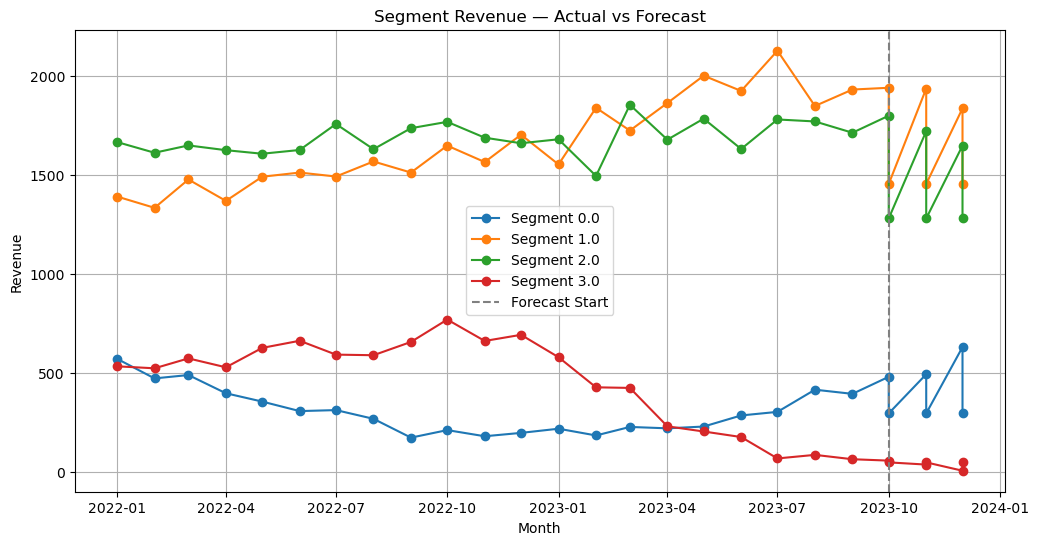

In [50]:
plt.figure(figsize=(12, 6))

for seg in df["segment"].unique():
    seg_data = df[df["segment"] == seg]
    
    plt.plot(
        seg_data["order_month"],
        seg_data["value"],
        marker="o",
        label=f"Segment {seg}"
    )

plt.axvline(
    df[df["type"] == "Forecast"]["order_month"].min(),
    linestyle="--",
    color="gray",
    label="Forecast Start"
)

plt.title("Segment Revenue — Actual vs Forecast")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
segment_summary = (
    df.groupby(["segment", "type"])["value"]
    .sum()
    .reset_index()
)

segment_summary


,segment,type,value
0,0.0,Actual,8034.000
1,0.0,Forecast,889.410
2,1.0,Actual,40584.000
3,1.0,Forecast,4363.505
4,2.0,Actual,40577.000
5,2.0,Forecast,3841.130
6,3.0,Actual,9786.000
7,3.0,Forecast,147.300


In [52]:
pivot_growth = segment_summary.pivot(
    index="segment",
    columns="type",
    values="value"
)

pivot_growth["growth_%"] = (
    (pivot_growth["Forecast"] - pivot_growth["Actual"])
    / pivot_growth["Actual"]
) * 100

pivot_growth


type,Actual,Forecast,growth_%
segment,,,
0.0,8034.0,889.410,-88.929425
1.0,40584.0,4363.505,-89.248214
2.0,40577.0,3841.130,-90.533726
3.0,9786.0,147.300,-98.494788


In [53]:
pivot_growth.to_csv(
    "core/data/processed/segment_growth_summary.csv"
)

print("✅ Segment growth summary saved")


✅ Segment growth summary saved
